# ECE 417  MP3: Face Detection using Faster RCNN

This MP is an implementation of the <a href="http://papers.nips.cc/paper/5638-faster-r-cnn-towards-real-time-object-detection-with-region-proposal-networks.pdf">Faster RCNN</a> object detector, to perform <a href="https://ieeexplore.ieee.org/abstract/document/7961803?casa_token=Iq_WWzkvf9UAAAAA:ObgVQqkbTdwZ5KEPLAUK6uABkfEMT0F7TUm_Y0mNOr5uEbFGY3cVN0mo8JQHqboUNsZtCEoa">face detection</a> using a small dataset extracted from the very large <a href="http://shuoyang1213.me/WIDERFACE/">WIDER FACE</a> dataset.

## Downloading the template, Writing your code, Debugging, Testing, and Submitting

* The template package that you should download is here: http://courses.engr.illinois.edu/ece417/fa2020/ece417_20fall_mp3.zip.
* When you download and unzip that package, you will find a file called mp3_overview.ipynb.  If you open that file using any ipython or Jupyter notebook, you will see a live version of the web page you  are looking at right now.
* The only code that you will submit is the file mp3.py.  The parts that you need to fill in are marked with `NotImplementedError`s. 
* As you edit mp3.py, you can see the results of your edits by running the  corresponding code blocks in this file.  Notice that each relevant code block starts with a `importlib.reload(mp3)`, which will reload your most recent edited version, and run  it.
* When everything on this page seems to run OK, you can run the unit tests by typing `python run_tests.py` or `python run_tests.py -j` in a console.
* When the unit tests all succeed on your own machine, you can try them on the autograder.  Just upload the file mp3.py (if you upload other files, they will not be graded).

The rest of this file contains code for debugging mp3.py.  If you are looking at this file on the web, you can browse the blocks below, to see what kind of material the MP will cover.  If you are interacting with this file on  your own machine, you can run the code yourself, to test your own version of mp3.py, and you can edit these code blocks as much as you want, in order to print out the variables, or any other debugging step that's useful to you.

In [29]:
import numpy  as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.figure
import importlib, os, sys, h5py

This block imports your mp3.py code:

In [30]:
import mp3
#importlib.reload(mp3)

## 0. Browsing the Data

First, we'll create a function that plots face rectangles on top  of the image.  Then we'll use it to look at some of the data.

In [31]:
def show_image_with_rectangles(image,rects):
    fig=plt.figure(figsize=(7,7))
    plt.imshow(image)
    for rect in rects:
        x = rect[0]+np.array([-rect[2]/2,rect[2]/2])
        y = rect[1]+np.array([-rect[3]/2,rect[3]/2])
        plt.plot(x,y[0]*np.ones(2),'c-',linewidth=3)
        plt.plot(x,y[1]*np.ones(2),'c-',linewidth=3)
        plt.plot(x[0]*np.ones(2),y,'c-',linewidth=3)
        plt.plot(x[1]*np.ones(2),y,'c-',linewidth=3)

It's good practice to use "importlib.reload" before you call anything from mp3.py.  That way, every time you make changes to that file, your changes will be drawn in to this notebook page immediately.  

This chunk of code loads in the mp3_dataset object.   We'll load in the first datum, and find out what members it contains.  

In [32]:
importlib.reload(mp3)
mp3_dataset = mp3.MP3_Dataset('data')
datum=mp3_dataset[0]
for k in datum.keys():
    print('Object %s has shape %s'%(k,datum[k].shape))

Object image has shape (224, 224, 3)
Object features has shape (1, 512, 14, 14)
Object rects has shape (3, 10)
Object target has shape (9, 196, 5)


Next, let's plot the image, and overlay its reference rectangles on top:

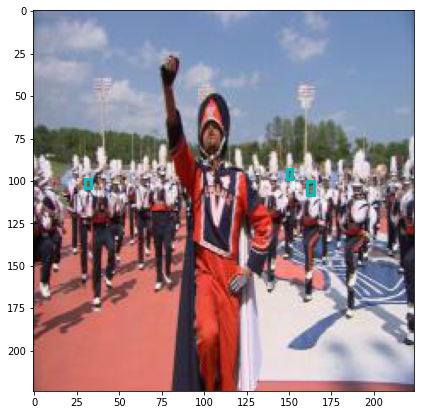

In [33]:
show_image_with_rectangles(datum['image'],datum['rects'])

Next, let's plot the anchor  rectangles.  For reasons of efficiency, the anchors are stored in the opposite order: anchors[i,xy,a] is the i'th term in the rectangle corresponding to the a'tjh anchor (0<=a<=8) associated with the xy'th image position (0<=xy<=195). In order to make it easier to plot, let's create a transposed version.

In [34]:
anchor_rects = np.transpose(mp3_dataset.anchors,[1,2,0])
[ mp3_dataset.anchors.shape, anchor_rects.shape ]

[(4, 196, 9), (196, 9, 4)]

In order to plot the smallest square at each anchor position, we just need to choose the zero'th anchor associated with each position.

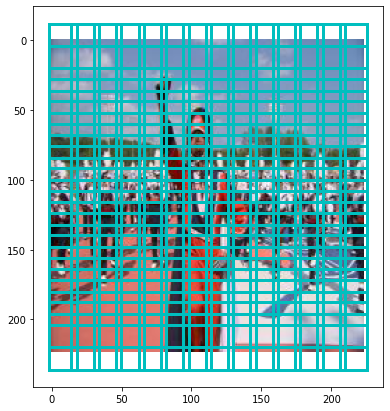

In [35]:
show_image_with_rectangles(datum['image'],anchor_rects[:,0,:])

To better understand the anchors, let's show all of the anchors associated with a position somewhere out in the middle of the image -- say, position number x=7, y=7 (thus xy = 7x14+7-1=104).

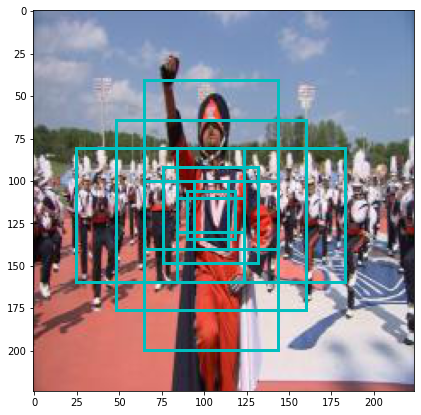

In [36]:
show_image_with_rectangles(datum['image'],anchor_rects[104,:,:])

Finally: the classification targets and regression targets are encoded into the array called datum['target'].  Specifically, the binary classification target for the a'th anchor at the i'th position is encoded as datum['target'][a,i,4], and if the classification target is 1, then the regression target is encoded as datum['target'][a,i,0:4].  

Notice the min(np.log(2),regression_target) here.  That keeps the computed rectangle from ever being more than twice as large as the anchor rectangle.  I recommend that you use such a limit in your code, because sometimes the neural net outputs get very large.

In [37]:
def target2rect(regression_target, anchor):
    rect = np.zeros(4)
    rect[0] = regression_target[0]*anchor[2]+anchor[0]
    rect[1] = regression_target[1]*anchor[3]+anchor[1]
    rect[2] = np.exp(min(np.log(2),regression_target[2]))*anchor[2]
    rect[3] = np.exp(min(np.log(2),regression_target[3]))*anchor[3]
    return(rect)

The Faster-RCNN coding scheme creates a target whenever a reference rectangle and an anchor rectangle have an IoU (intersection-over-union) greater than 0.7.  For that reason, there are a lot more target rectangles than there were reference rectangles:

In [38]:
target_rects = []
for a in range(9):
    for i in range(196):
        if datum['target'][a,i,4]==1:
            rect = target2rect(datum['target'][a,i,0:4],anchor_rects[i,a,:])
            target_rects.append(rect)
np.array(target_rects).shape

(411, 4)

If we plot the target rectangles, though, we should see that the number of __distinct__ target rectangles is just the same as the number of reference rectangles.  All of the extra targets are just duplicates of the same original references:

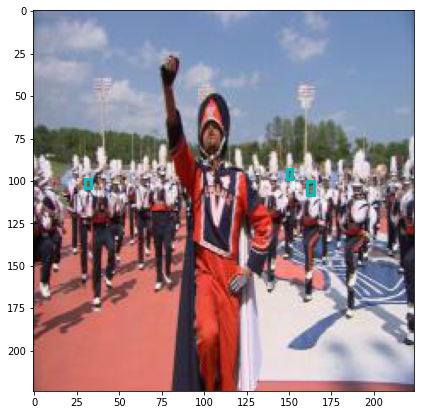

In [39]:
show_image_with_rectangles(datum['image'],target_rects)

Now that we've seen all of those things for one of the data, go up to the top of this section and choose datum 1, or 2, or 999  (any number less than 1000), in order to look at a different image.

## 2. Testing the Face Detector

First, let's test the face detector, using the weights provided to you in 'weights_trained.hdf5'.  These have been trained partway, using the provided 200-file training database. 

If you want to compare your results to the distributed results, go back to the beginning of the previous section and re-load mp3_dataset[0].  Then use this code to load the pre-trained weights:

In [40]:
importlib.reload(mp3)
W1,W2 = mp3.load_weights('weights_trained.hdf5')
[W1.shape, W2.shape]

[(4608, 512), (9, 512, 5)]

### 2.1 todo_concatenate

One of the secrets of Faster RCNN is that it does not train the whole stack of ConvNets directly.  Instead, it uses a pre-trained imagenet classifier called VGG16. VGG16 starts with a standardized 224x224 input image.  It processes that through a stack of 16 convolutional layers, interspersed with 4 max-pooling layers, so that the output channels are (224/2^4)=14 rows, and 14 columns.  There are 512 channels.

Faster RCNN determines whether or not there is any face, in position (y,x) (0<=x,y<=13) of the low-dimensional image, by concatenating all of the 512d vectors from all neighboring positions.  Thus the final vector should be vector[y-1,x-1], vector[y,x-1], vector[y+1,x-1], vector[y-1,x], ..., vector[y+1,x+1], all concatenated together.  

We can visualize this process by summing across the channels, and plotting it as a 14x14 image.  After we create the concatenated feature vector, its 0'th column should be the same image shifted one pixel to the right and downward, its 512'th column should be just one pixel downward, and so on.  Here are the results from the solutions.hdf5 file.  Notice that, when a row or column is shifted in from outside the image, we solve that problem by copying in the last row or column.  Notice, too, that most of the VGG16 features are zero-valued.

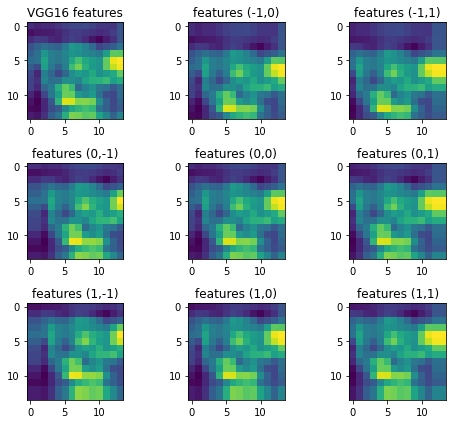

In [41]:
with h5py.File('solutions.hdf5','r') as f:
    concatenation_solution = f['concatenation'][:]
    features_solution = f['features'][:]
fig,axs=plt.subplots(3,3,figsize=(7,6))
img = np.sum(features_solution[0,:,:,:],axis=0)
axs[0,0].imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))
axs[0,0].set_title('VGG16 features')
for i in range(1,9):
    img = np.sum(concatenation_solution[:,(512*i):(512*(i+1))],axis=1).reshape((14,14))
    j,k = np.unravel_index(i,(3,3))
    axs[j,k].imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))
    axs[j,k].set_title('features (%d,%d)'%(j-1,k-1))
fig.tight_layout()

Here's the same thing from your mp3.py file:

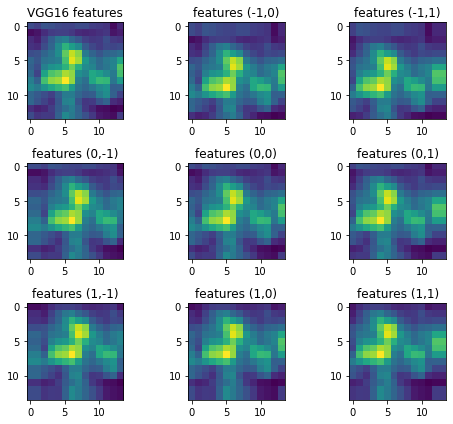

In [42]:
importlib.reload(mp3)
concatenation = mp3.todo_concatenate(datum['features'])
fig,axs=plt.subplots(3,3,figsize=(7,6))
img = np.sum(datum['features'][0,:,:,:],axis=0)
axs[0,0].imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))
axs[0,0].set_title('VGG16 features')
for i in range(1,9):
    img = np.sum(concatenation[:,(512*i):(512*(i+1))],axis=1).reshape((14,14))
    j,k = np.unravel_index(i,(3,3))
    axs[j,k].imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))
    axs[j,k].set_title('features (%d,%d)'%(j-1,k-1))
fig.tight_layout()

In [573]:
(datum['features']>0).nonzero()[1].shape


(3609,)

## 2.2 todo_forward

Next, implement a two-layer feedforward network.  The formula looks something like this:
$$h = ReLU(x W_1)$$
$$\hat{y} = g(h W_{2})$$
where $x$ is one of the vectors created by todo_concatenate, the first four elements of $g(e)$ are linear (generating regression targets), and the last element is a logistic sigmoid (generating  a  classification target). 

In [43]:
with h5py.File('solutions.hdf5','r') as f:
    hypothesis_solution = f['hypothesis'][:]
hypothesis_solution.shape
np.max(np.abs(W1))

0.008622920073184636

In [44]:
(a,i)=np.unravel_index(np.argmax(hypothesis_solution[:,:,4]),(9,196))
hypothesis_solution[a,i,:]

array([ 1.63635046e-07, -2.24746376e-05, -6.65449779e-05, -5.25878658e-05,
        5.00004344e-01])

Thus, one of the things we can plot is the probability of a face image, for each of the nine anchors,  at each position in the image.  Here's what that looks like for the stored solutions:


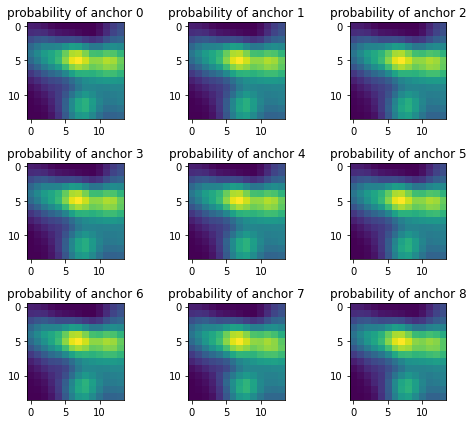

In [45]:

fig,axs=plt.subplots(3,3,figsize=(7,6))
for a in range(9):
    img = hypothesis_solution[a,:,4].reshape((14,14))
    j,k = np.unravel_index(a,(3,3))
    axs[j,k].imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))
    axs[j,k].set_title('probability of anchor %d'%(a))
fig.tight_layout()

... and here is the same image, for your own code mp3.py:

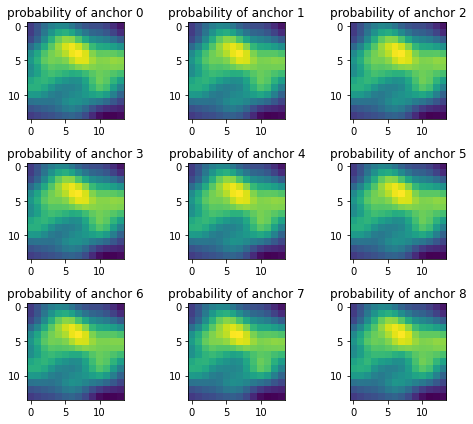

In [47]:
importlib.reload(mp3)
hypothesis, hidden = mp3.todo_forward(concatenation,W1,W2)
fig,axs=plt.subplots(3,3,figsize=(7,6))
for a in range(9):
    img = hypothesis[a,:,4].reshape((14,14))
    j,k = np.unravel_index(a,(3,3))
    axs[j,k].imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))
    axs[j,k].set_title('probability of anchor %d'%(a))
fig.tight_layout()

### 2.3 todo_detect_rectangles

Now, finally, we can see which rectangles the neural net has told us to detect!  Your  function todo_detect_rectangles should find the (a,i) pairs that the neural net thinks are  most probable (highest classification probability).  For each one, it should convert the regression output back into an  image rectangle, and append it to the best_rects output.  Then we can plot those best_rects on the original image.

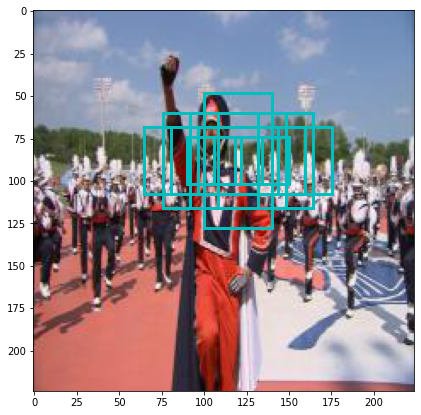

In [48]:
with h5py.File('solutions.hdf5','r') as f:
    best_rects_solution = f['best_rects'][:]
show_image_with_rectangles(datum['image'],best_rects_solution)

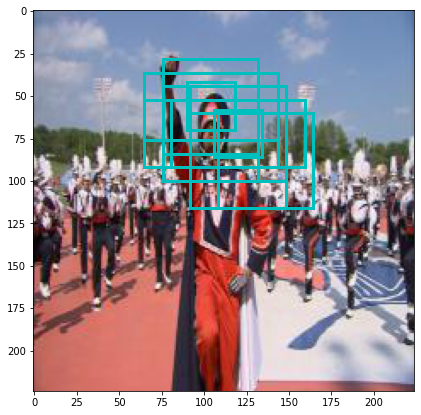

In [52]:
importlib.reload(mp3)
best_rects = mp3.todo_detect_rectangles(hypothesis, 10, mp3_dataset)
show_image_with_rectangles(datum['image'],best_rects)

## 3. Training the neural network

### 3.1 todo_outputgrad

Now we need to compute the loss.  For Faster RCNN, the loss has two parts:
$${\mathcal L} = {\mathcal L}_{SSE} + {\mathcal L}_{BCE}$$
where
$${\mathcal L}_{SSE} = \frac{1}{2}\sum_{i=0}^{195}\sum_{a=0}^8 \hat{y}_c[a,i]\Vert y_r[a,i]-\hat{y}_r[a,i]\Vert^2$$
with $\hat{y}_c[a,i]$ equal to the classification output (hypothesis[a,i,4]), and 
$\hat{y}_r[a,i]$ equal to the regression output (hypothesis[a,i,0:4]).  The other term in the loss, ${\mathcal L}_{BCE}$, is the usual binary cross entropy loss for $\hat{y}_c[a,i]$, summed over $a$ and $i$.

Actually, we don't need the loss.  We just need the derivative of the loss with respect to the excitations in the output layer of the neural network:
$$\textrm{outputgrad}[a,i,k]=\frac{d{\mathcal L}}{de[a,i,k]}$$
where $e[a,i,k]$ is the excitation (before the sigmoid nonlinearity)  for the a'th anchor at the i'th image position, for the k'th network output.

Again, we can show that derivative as a set of nine images, one for each of the anchors:

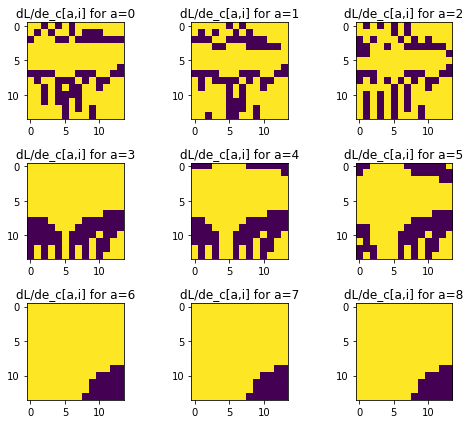

In [580]:
with h5py.File('solutions.hdf5','r') as f:
    outputgrad_solutions = f['outputgrad'][:]
fig,axs=plt.subplots(3,3,figsize=(7,6))
for a in range(9):
    img = outputgrad_solutions[a,:,4].reshape((14,14))
    j,k = np.unravel_index(a,(3,3))
    axs[j,k].imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))
    axs[j,k].set_title('dL/de_c[a,i] for a=%d'%(a))
fig.tight_layout()

... and here are the same images, for your code mp3.py:

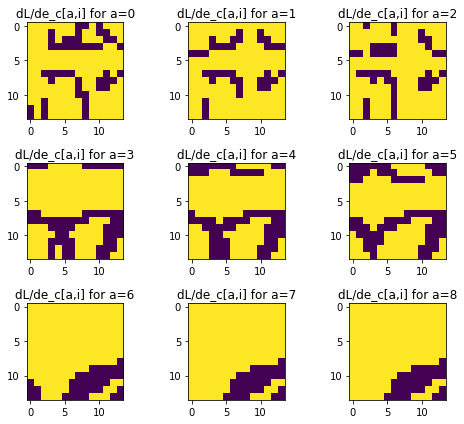

In [53]:
importlib.reload(mp3)
outputgrad = mp3.todo_outputgrad(hypothesis, datum['target'])
fig,axs=plt.subplots(3,3,figsize=(7,6))
for a in range(9):
    img = outputgrad[a,:,4].reshape((14,14))
    j,k = np.unravel_index(a,(3,3))
    axs[j,k].imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))
    axs[j,k].set_title('dL/de_c[a,i] for a=%d'%(a))
fig.tight_layout()

### 3.2 todo_backprop

Now let's backprop.  Remember that outputgrad=dL/de for excitations in the output layer.  We want to backprop that to get backprop=dL/de for excitations in the hidden layer.  This signal no longer depends on the anchor (we have just one hidden layer, shared among all nine anchors), but it still depends on the (x,y) coordinates.  Let's plot the L1 norm of the gradient vector, as a function of (x,y) coordinates:

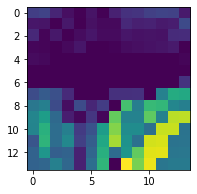

In [54]:
with h5py.File('solutions.hdf5','r') as f:
    backprop_solutions = f['backprop'][:]
fig,ax=plt.subplots(figsize=(3,3))
img = np.sum(np.absolute(backprop_solutions),axis=1).reshape((14,14))
ax.imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))

Here's the same thing for your mp3.py code:

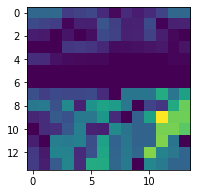

In [56]:
importlib.reload(mp3)
backprop = mp3.todo_backprop(outputgrad,hidden,W2)
fig,ax=plt.subplots(figsize=(3,3))
img = np.sum(np.absolute(backprop),axis=1).reshape((14,14))
ax.imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))

### 3.3 todo_weightgrad and todo_update_weights

Then, we combine the forward-prop and back-prop to find out what is dL/dw for each element, w, of either of the weight matrices.  The weight matrices are shared across all  (x,y) positions in the image, so we can't plot it as a function of x and y.  Instead, let's just plot two columns: the left column has the original values, weight gradient, and updated values of W1.  The right column has the same things, for W2.

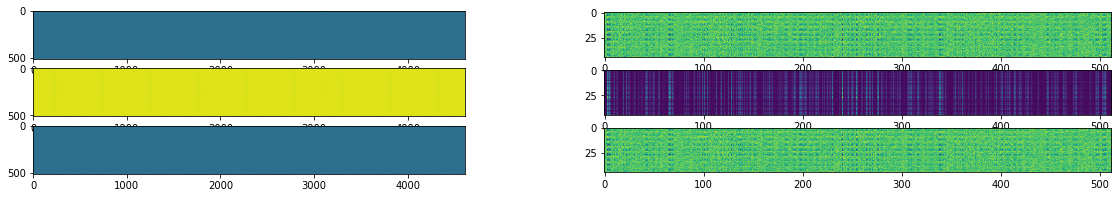

In [58]:
with h5py.File('solutions.hdf5','r') as f:
    dW1_solutions = f['dW1'][:]
    dW2_solutions = f['dW2'][:]
fig,axs=plt.subplots(3,2,figsize=(20,3))
img = W1.T
axs[0,0].imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))
img = dW1_solutions.T
axs[1,0].imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))
img = (W1 - 0.01*dW1_solutions).T
axs[2,0].imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))

img = np.concatenate([W2[a,:,:].T for a in range(9)])
axs[0,1].imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))
img = np.concatenate([dW2_solutions[a,:,:].T for a in range(9)])
axs[1,1].imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))
img = np.concatenate([(W2[a,:,:]-dW2_solutions[a,:,:]).T for a in range(9)])
axs[2,1].imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))


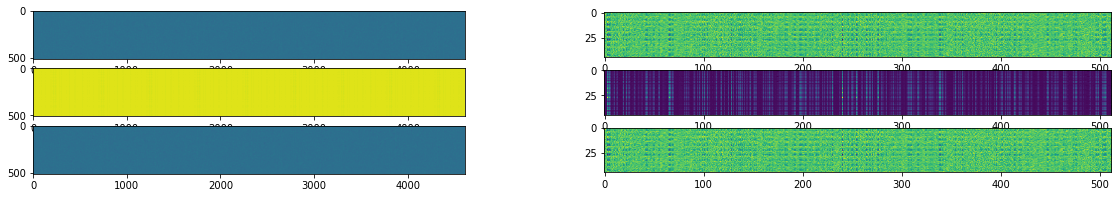

In [59]:
importlib.reload(mp3)
dW1, dW2 = mp3.todo_weightgrad(outputgrad, backprop, hidden, concatenation)
fig,axs=plt.subplots(3,2,figsize=(20,3))
img = W1.T
axs[0,0].imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))
img = dW1_solutions.T
axs[1,0].imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))

img = np.concatenate([W2[a,:,:].T for a in range(9)])
axs[0,1].imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))
img = np.concatenate([dW2_solutions[a,:,:].T for a in range(9)])
axs[1,1].imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))

new_W1, new_W2 = mp3.todo_update_weights(W1,W2,dW1, dW2, 0.01)
img = new_W1.T
axs[2,0].imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))
img = np.concatenate([(new_W2[a,:,:]).T for a in range(9)])
axs[2,1].imshow((img-np.amin(img))/(1e-6+np.amax(img)-np.amin(img)))


### 3.4 Test it again, to see if it got a little better

The neural net probably hasn't improved after just one training image.  But let's test it anyway.

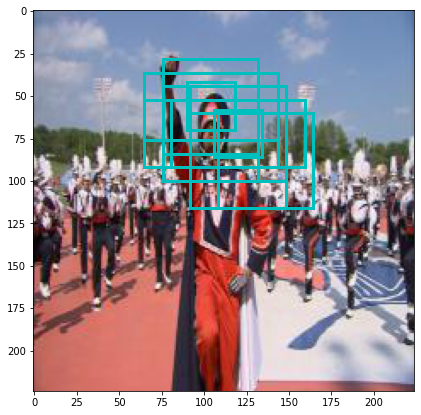

In [61]:
importlib.reload(mp3)
new_hypothesis, new_hidden = mp3.todo_forward(concatenation,new_W1,new_W2)
new_best_rects = mp3.todo_detect_rectangles(new_hypothesis, 10, mp3_dataset)
show_image_with_rectangles(datum['image'],new_best_rects)

## 4. Conclusion

Congratulations --- you've learned how to train a Faster-RCNN object detector! You probably shouldn't expect that a neural net trained on these 200 images will generalize well to other images, but if you used the same procedure for all 13,000 images in the WIDER face dataset, you should get pretty reasonable performance.  In the mean time, type `python run_tests.py` to make sure you pass all of the tests, and when you do, go ahead and submit your mp3.py file to the autograder.   Again, congratulations!